Using the cluster_feats we will finally predict the metrics of interest. There are many ways to evaluate our results, I do the following: <br>
1) randomized CV - use 5-fold cross validation randomly on all clusters, all countries <br>
2) randomized CV per country - use 5-fold cross validation within a country for all countries <br>
3) spatial CV per country - use 5-fold cross validation but folds consist of clusters that are geographically close <br>
4) cross-country CV - we have three countries, so hold one country out and perform cross validation <br>

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats

In [2]:
BASE_DIR = '..'
RANDOM_SEED = 7 # for reproducibility
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
COUNTRY = 'malawi_2016'

PROCESSED_DIR = os.path.join(COUNTRIES_DIR, COUNTRY, 'processed')
RESULTS_DIR = os.path.join(BASE_DIR, 'results', COUNTRY)
FIGURES_DIR = os.path.join(BASE_DIR, 'figures', COUNTRY)

In [3]:
import sys
sys.path.append(BASE_DIR)
from utils import merge_on_lat_lon, assign_groups, run_randomized_cv, run_spatial_cv, RidgeEnsemble

In [30]:
os.makedirs(FIGURES_DIR, exist_ok=True)

# Predict Consumption

In [4]:
def load_data(metric):
    '''
    Loads the train/valid features and dataframes
    '''
    country_results_dir = os.path.join(RESULTS_DIR, metric, 'cnn')
    country_processed_dir = os.path.join(COUNTRIES_DIR, COUNTRY, 'processed')
    df_clusters = pd.read_csv(os.path.join(country_processed_dir, 'clusters.csv'))
    
    x_train = np.load(os.path.join(country_results_dir, f'cluster_feats_train_{metric}.npy'))
    cluster_train = pickle.load(open(os.path.join(country_results_dir, f'cluster_order_train_{metric}.pkl'), 'rb'))
    cluster_train = pd.DataFrame.from_records(cluster_train, columns=['cluster_lat', 'cluster_lon'])
    cluster_train['feat_index'] = np.arange(len(cluster_train))
    df_train = merge_on_lat_lon(df_clusters, cluster_train, keys=['cluster_lat', 'cluster_lon'])
    df_train.sort_values('feat_index', ascending=True, inplace=True)
    
    x_valid = np.load(os.path.join(country_results_dir, f'cluster_feats_valid_{metric}.npy'))
    cluster_valid = pickle.load(open(os.path.join(country_results_dir, f'cluster_order_valid_{metric}.pkl'), 'rb'))
    cluster_valid = pd.DataFrame.from_records(cluster_valid, columns=['cluster_lat', 'cluster_lon'])
    cluster_valid['feat_index'] = np.arange(len(cluster_valid))
    df_valid = merge_on_lat_lon(df_clusters, cluster_valid, keys=['cluster_lat', 'cluster_lon'])
    df_valid.sort_values('feat_index', ascending=True, inplace=True)
    
    assert len(cluster_train) + len(cluster_valid) == len(df_clusters)
    assert len(df_train) + len(df_valid) == len(df_clusters)
    return x_train, df_train, x_valid, df_valid

In [5]:
def test_randomized_cv(x, y):
    print("Testing randomized CV:\n--------------\n")
    r2_avg, yhat = run_randomized_cv(x, y, random_seed=RANDOM_SEED, to_print=False)
    r2_preds = r2_score(y, yhat)
    r2_pearson = stats.pearsonr(y, yhat)[0]**2
    print(f"For {COUNTRY}, r2 avg: {r2_avg}, r2 combined preds: {r2_preds}, r2 pearson: {r2_pearson}")
    
def test_spatial_cv(x, y, df):
    print("Testing spatial CV:\n--------------\n")
    groups, _ = assign_groups(df, k=5, random_seed=RANDOM_SEED)
    r2_avg, yhat = run_spatial_cv(x, y, groups, random_seed=RANDOM_SEED, to_print=False)
    r2_preds = r2_score(y, yhat)
    r2_pearson = stats.pearsonr(y, yhat)[0]**2
    print(f"For {COUNTRY}, r2 avg: {r2_avg}, r2 combined preds: {r2_preds}, r2 pearson: {r2_pearson}")

In [6]:
def test_metric_helper(x_train, y_train, groups_train, x_valid, y_valid):
    print("running randomized cv...")
    r2_rcv, _, ridges_rcv, scalers_rcv = run_randomized_cv(x_train, y_train, random_seed=RANDOM_SEED)
    re_rcv = RidgeEnsemble(ridges_rcv, scalers_rcv)
    yhat_rcv_valid = re_rcv.predict(x_valid)
    r2_rcv_valid = r2_score(y_valid, yhat_rcv_valid)
    print(f"randomized cv r2: {r2_rcv}, validation r2: {r2_rcv_valid}")
    pearson_r2_rcv = stats.pearsonr(y_valid, yhat_rcv_valid)[0]**2
    print(f"validation pearson R squared: {pearson_r2_rcv}")
    
    print("running spatial cv...")
    r2_scv, _, ridges_scv, scalers_scv = run_spatial_cv(x_train, y_train, groups_train, random_seed=RANDOM_SEED)
    re_scv = RidgeEnsemble(ridges_scv, scalers_scv)
    yhat_scv_valid = re_scv.predict(x_valid)
    r2_scv_valid = r2_score(y_valid, yhat_scv_valid)
    print(f"spatial cv r2: {r2_scv}, validation r2: {r2_scv_valid}")
    pearson_r2_scv = stats.pearsonr(y_valid, yhat_scv_valid)[0]**2
    print(f"validation pearson R squared: {pearson_r2_scv}")
    
def test_metric(metric):
    x_train_mw, df_train_mw, x_valid_mw, df_valid_mw = load_data(metric)
    y_train = df_train_mw[metric].values
    y_valid = df_valid_mw[metric].values
    groups_train, _ = assign_groups(df_train_mw, 5, random_seed=RANDOM_SEED)
    test_metric_helper(x_train_mw, y_train, groups_train, x_valid_mw, y_valid)
    
def test_metric_with_lenz(df_lenz, metric):
    lenz_x_cols = df_lenz.columns.drop(['cluster_lat', 'cluster_lon'])
    x_train_mw, df_train_mw, x_valid_mw, df_valid_mw = load_data(metric)
    df_train_combined = merge_on_lat_lon(df_lenz, df_train_mw).sort_values('feat_index', ascending=True)
    df_valid_combined = merge_on_lat_lon(df_lenz, df_valid_mw).sort_values('feat_index', ascending=True)
    assert(len(df_train_combined) == len(df_train_mw))
    assert(len(df_valid_combined) == len(df_valid_mw))
    x_train_lenz = df_train_combined[lenz_x_cols].values
    x_valid_lenz = df_valid_combined[lenz_x_cols].values
    y_train = df_train_combined[metric].values
    y_valid = df_valid_combined[metric].values
    groups_train, _ = assign_groups(df_train_mw, 5, random_seed=RANDOM_SEED)
    
    print('CNN performance:')
    test_metric_helper(x_train_mw, y_train, groups_train, x_valid_mw, y_valid)
    print()
    
    print('Lenz performance:')
    test_metric_helper(x_train_lenz, y_train, groups_train, x_valid_lenz, y_valid)
    print()
    
    print('CNN + Lenz performance:')
    x_train_combined = np.append(x_train_mw, x_train_lenz, axis=1)
    x_valid_combined = np.append(x_valid_mw, x_valid_lenz, axis=1)
    test_metric_helper(x_train_combined, y_train, groups_train, x_valid_combined, y_valid)
    

In [8]:
# these will work as is
# the code that comes after uses additional work from previous paper Lenz et al
# at the moment that code is not shown in this repo
# test_metric('rCSI')
# test_metric('FCS')
# test_metric('HDDS')

In [9]:
df_lenz = pd.read_csv(os.path.join(PROCESSED_DIR, 'mw_no_asset.csv'))
df_lenz.drop(['ea_id', 'HHID', 'FS_year', 'FS_month', 'FCS', 'HDDS', 'rCSI',
             'region_north', 'region_central', 'rural', 'nutri_severe_constraint',
             'nutri_moderate_constraint', 'nutri_reten_severe_constraint', 'dummy_terrain_rough'],
            axis=1, inplace=True)
df_lenz.rename(columns={'lat_modified': 'cluster_lat',
                       'lon_modified': 'cluster_lon'}, inplace=True)
df_lenz = df_lenz.groupby(['cluster_lat', 'cluster_lon']).mean().reset_index()

In [11]:
test_metric_with_lenz(df_lenz, 'rCSI')

CNN performance:
running randomized cv...
randomized cv r2: 0.23652486135115924, validation r2: 0.2266617008771773
validation pearson R squared: 0.23895947144078647
running spatial cv...
spatial cv r2: -0.004706973265082337, validation r2: 0.21790119643903927
validation pearson R squared: 0.23777776342364979

Lenz performance:
running randomized cv...
randomized cv r2: 0.19157550744113647, validation r2: 0.10546423222850254
validation pearson R squared: 0.11356375234821336
running spatial cv...
spatial cv r2: -0.09118442750403769, validation r2: 0.10385252043882931
validation pearson R squared: 0.10605419087669815

CNN + Lenz performance:
running randomized cv...
randomized cv r2: 0.2883685622239858, validation r2: 0.24985636992709115
validation pearson R squared: 0.2506063843665234
running spatial cv...


/opt/conda/envs/predicting-poverty-replication/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


spatial cv r2: -3.6272926508985726, validation r2: -0.28310376536868165
validation pearson R squared: 0.060826752327573945


In [12]:
test_metric_with_lenz(df_lenz, 'FCS')

CNN performance:
running randomized cv...
randomized cv r2: 0.6764587141769116, validation r2: 0.5216566452928635
validation pearson R squared: 0.5273753223135647
running spatial cv...
spatial cv r2: 0.44331127335517806, validation r2: 0.5243843993719107
validation pearson R squared: 0.529037742612119

Lenz performance:
running randomized cv...
randomized cv r2: 0.2923584246296958, validation r2: 0.15251367960406503
validation pearson R squared: 0.17488352714767194
running spatial cv...
spatial cv r2: -0.959669602586733, validation r2: 0.13300248145668592
validation pearson R squared: 0.16460981902847518

CNN + Lenz performance:
running randomized cv...
randomized cv r2: 0.678636171381391, validation r2: 0.5295725759707491
validation pearson R squared: 0.5351504935064391
running spatial cv...
spatial cv r2: 0.4232089179586168, validation r2: 0.5297588752190538
validation pearson R squared: 0.5349716665727139


In [13]:
test_metric_with_lenz(df_lenz, 'HDDS')

CNN performance:
running randomized cv...
randomized cv r2: 0.5536879346780037, validation r2: 0.4121535309695724
validation pearson R squared: 0.4231647429456188
running spatial cv...
spatial cv r2: 0.35973326305990483, validation r2: 0.40667362542493213
validation pearson R squared: 0.41588990603859294

Lenz performance:
running randomized cv...
randomized cv r2: 0.2980209919469834, validation r2: 0.1782060092404023
validation pearson R squared: 0.2041147842809073
running spatial cv...
spatial cv r2: -0.15380159247163938, validation r2: 0.16352338869744176
validation pearson R squared: 0.18592641537331384

CNN + Lenz performance:
running randomized cv...
randomized cv r2: 0.581669731141842, validation r2: 0.45140359383206674
validation pearson R squared: 0.4605220841389348
running spatial cv...
spatial cv r2: 0.3650193086298616, validation r2: 0.441968687716644
validation pearson R squared: 0.4495891237656618


# Plotting

In [48]:
def plot_predictions(y, yhat, r2, title, max_y=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    fig = plt.figure(figsize=(8,5))
    plt.scatter(y, yhat, alpha=0.6)    
    y_i = np.unique(y)
    yhat_i = np.poly1d(np.polyfit(y, yhat, 1))(y_i)
    plt.plot(y_i, yhat_i, color='g')
    xloc = 0.75 * max(y_i)
    yloc = 0.75 * max(yhat_i)
    plt.text(xloc, yloc, f'r^2={round(r2, 2)}', size=12)
    plt.xlabel('Actual Consumption($/day)')
    plt.ylabel('Predicted Consumption($/day)')
    plt.title(f'{title}')
    return fig

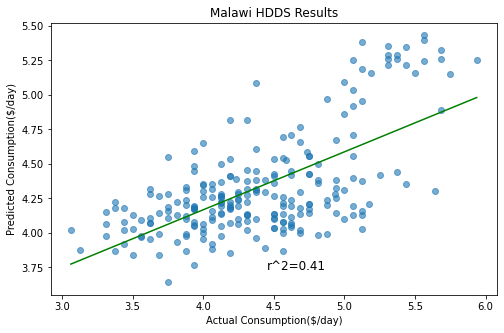

In [50]:
metric = 'HDDS'
x_train_mw, df_train_mw, x_valid_mw, df_valid_mw = load_data(metric)
y_train = df_train_mw[metric].values
y_valid = df_valid_mw[metric].values
r2_rcv, _, ridges_rcv, scalers_rcv = run_randomized_cv(x_train_mw, y_train, random_seed=RANDOM_SEED)
re_rcv = RidgeEnsemble(ridges_rcv, scalers_rcv)
yhat_rcv_valid = re_rcv.predict(x_valid_mw)
r2_rcv_valid = r2_score(y_valid, yhat_rcv_valid)
title = f'Malawi {metric} Results'
fig = plot_predictions(y_valid, yhat_rcv_valid, r2_rcv_valid, f'Malawi {metric} Results')

name = title.replace(' ', '_')
fig.savefig(os.path.join(FIGURES_DIR, f'{name}.png'))